In [4]:
import pandas as pd
import numpy as np
from scipy.stats import norm
from scipy import stats
import geopandas as gpd
from shapely.geometry import Point, Polygon
import matplotlib.pyplot as plt
from matplotlib import style
style.use('fivethirtyeight')
import seaborn as sns 
sns.set_theme()
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import r2_score as r2
from sklearn.metrics import mean_absolute_error as mae
import warnings
warnings.filterwarnings('ignore')

In [12]:
nyc = pd.read_csv('nyclistings.csv')

Data Exploration

In [6]:
nyc['neighbourhood_group'].value_counts()

NameError: name 'nyc' is not defined

In [ ]:
nyc.isnull().sum()

In [ ]:
nyc.price.describe

Data Visualization <br> - Geospatial mapping of NYC visualizing the relations between boroughs and price <br> - Pie charts visualizing distributions between Room Types, Neighbourhood Groups, and Popular Neighbourhoods <br> - Heatmap demonstrating correlation between price and features <br> - Visual Distribution of Price

array([[<Axes: title={'center': 'latitude'}>,
        <Axes: title={'center': 'longitude'}>,
        <Axes: title={'center': 'minimum_nights'}>],
       [<Axes: title={'center': 'number_of_reviews'}>,
        <Axes: title={'center': 'reviews_per_month'}>,
        <Axes: title={'center': 'calculated_host_listings_count'}>],
       [<Axes: title={'center': 'availability_365'}>,
        <Axes: title={'center': 'price_log'}>, <Axes: >]], dtype=object)

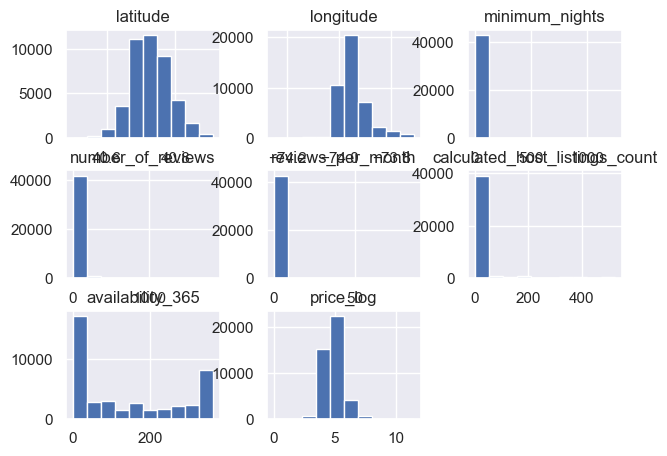

In [18]:
nyc.hist()

In [ ]:
plt.figure(figsize=(15,8))
sns.scatterplot(data=nyc, x='latitude', y='longitude')

In [ ]:
# Dataframe for geospatial visualization
nyc_map = nyc[['latitude','longitude','price']]
nyc_map

In [ ]:
# Geospatial data of new york city
map = gpd.read_file('/Users/alpha/Desktop/Projects/nycairbnb/Shapefiles and base map/geo_export_3e1c3d29-a810-4698-9c8c-0c853f1f9201.shp')

In [ ]:
# Coordinate reference system and longtitude/latitude coordinate system
crs = {'init':'epsg:4326'}

In [ ]:
# Generating points for using our coordinates
geometry = [Point(xy) for xy in zip(nyc_map['longitude'], nyc_map['latitude'])]
geometry[:4]

In [ ]:
# Generating new table with geopandas
geo_nyc = gpd.GeoDataFrame(nyc_map, crs=crs, geometry=geometry)
geo_nyc.head()

In [ ]:
fig,ax = plt.subplots(figsize= (30,30))
map.plot(ax=ax, alpha=.4)

geo_nyc.plot(column='price', ax=ax, markersize=2, alpha=.7, cmap='hot', vmin=0, vmax=1000)

ax.set_xlabel('Latitude')
ax.set_ylabel('Longitude')
ax.set_title('Relationship Between Boroughs and AirBnb Prices')

# Setting a color gradient for each point between 0-1000 based on price
sm = plt.cm.ScalarMappable(cmap='hot_r', norm=plt.Normalize(vmin=0,vmax=1000))

# Creating color bar as legend 
cbar = plt.colorbar(sm ,fraction=0.03, pad=0.04)
cbar.set_label('Price in USD ($)')

In [ ]:
fig = plt.figure(figsize=(10,10))
nyc['room_type'].value_counts().plot(kind='pie',  autopct='%1.0f%%', startangle=360, fontsize=13, pctdistance=1.1, labeldistance=1.2)

In [ ]:
fig = plt.figure(figsize=(10,10))
nyc['neighbourhood_group'].value_counts().plot(kind='pie',  autopct='%1.0f%%', startangle=360, fontsize=13, pctdistance=1.1, labeldistance=1.2)

In [ ]:
fig = plt.figure(figsize=(10,10))
nyc['neighbourhood'].sort_values().value_counts().head(20).plot(kind='pie',  autopct='%1.0f%%', startangle=360, fontsize=13, pctdistance=1.1, labeldistance=1.2)

In [ ]:
#corr = nyc.corr()
plt.figure(figsize=(15,8))
sns.heatmap(nyc.corr(), annot=True, cmap='YlGnBu')

In [ ]:
plt.figure(figsize=(10,10))
sns.distplot(nyc['price'], fit=norm)
plt.title("Price Distribution Plot",size=15, weight='bold')

Normalizing Price with log transformation due to having a skewed distribution, easier to interpret data for statistical analysis. <br> Price now has a normal distribution

In [13]:
nyc["price_log"] = np.log(nyc.price+1)
nyc = nyc.drop(columns=["price"])

In [ ]:
plt.figure(figsize=(12,10))
sns.distplot(nyc['price_log'], fit=norm)
plt.title("Log-Price Distribution Plot",size=15, weight='bold')

Cleaning Dataset
- Filling in missing values for reviews per month with mean, which is ideal in this case
- Dropping unnecessary columns

In [14]:
nyc["reviews_per_month"].fillna(nyc["reviews_per_month"].mean(), inplace=True)

In [15]:
nyc = nyc.drop(columns=['id', 'host_id', 'name', 'host_name', 'last_review', 'number_of_reviews_ltm', 'license'], axis=1)

Proprocessing Data <br> - Encoding categorical features into numerical values  <br> - Scaling the training data for machine learning models

In [16]:
ohe = OneHotEncoder()
scaler = StandardScaler()

nyc_cat = nyc[['neighbourhood_group', 'neighbourhood', 'room_type']]
nyc_cat = ohe.fit_transform(nyc_cat).toarray()

nyc_num = nyc.drop(columns=['neighbourhood_group', 'neighbourhood', 'room_type', 'price_log'])
nyc_num = scaler.fit_transform(nyc_num)

preprocessed = np.concatenate([nyc_num, nyc_cat], axis=1)

Partitioning Dataset into Train, Validation, and Test samples 
- Partition dataset
- Creating X variables for model prediction
- Creating Y variables for actual price
- Verfiyng shape of partitioned datasets

In [42]:
X_train, X_test, X_val = preprocessed[:30000], preprocessed[30000:36465], preprocessed[36465:]
y_train, y_test, y_val = nyc[:30000]['price_log'], nyc[30000:36465]['price_log'], nyc[36465:]['price_log']
X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape 

((30000, 239), (6466, 239), (6465, 239), (30000,), (6466,), (6465,))

Model Building
- Used LinearRegression, KNeighborsRegressor, RandomForestRegressor, GradientBoostingRegressor 
- Implemented Mean Square Error to show how accurately model predicts price
- Added some parameters to fine tune models
- Visualizing best model with Scatterplots

In [61]:
lr = LinearRegression().fit(X_train, y_train)
mse(lr.predict(X_train), y_train, squared=False), mse(lr.predict(X_val), y_val, squared=False)

(0.5613651535428507, 0.6698835907746352)

In [64]:
r2(y_test, lr.predict(X_test))

0.45016760685557033

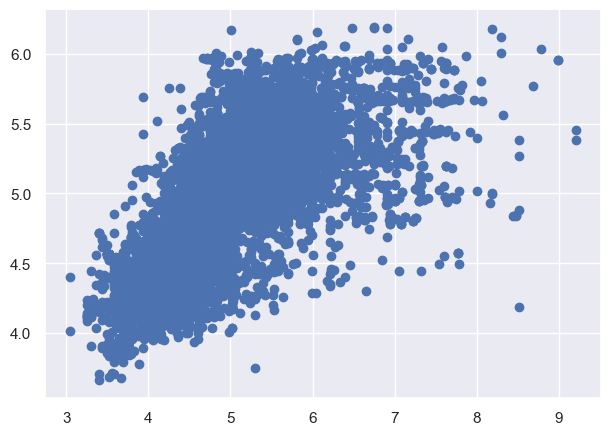

In [86]:
plt.scatter(y_val, lr.predict(X_val))

In [87]:
from sklearn.neighbors import KNeighborsRegressor

knn = KNeighborsRegressor(n_neighbors=100).fit(X_train, y_train)
mse(knn.predict(X_train), y_train, squared=False), mse(knn.predict(X_val), y_val, squared=False), mse(knn.predict(X_test), y_test, squared=False)

(0.5429249381126539, 0.6760208164487355, 0.5508921902306775)

In [88]:
r2_score(y_test, knn.predict(X_test))

0.4975354211711176

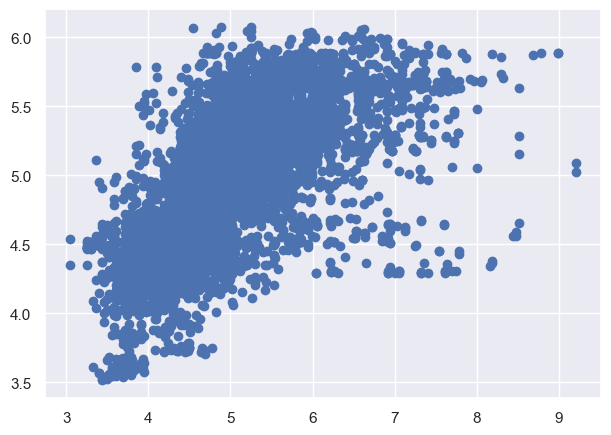

In [89]:
plt.scatter(y_val, knn.predict(X_val))

In [90]:
from sklearn.ensemble import RandomForestRegressor 

rfr = RandomForestRegressor(max_depth=5).fit(X_train, y_train)
mse(rfr.predict(X_train), y_train, squared=False), mse(rfr.predict(X_val), y_val, squared=False)

(0.538404044990708, 0.6256067040442974)

In [91]:
r2(y_test, rfr.predict(X_test))

0.5087121121033845

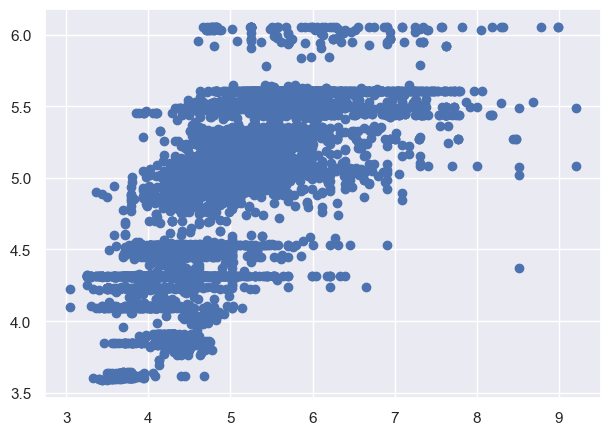

In [92]:
plt.scatter(y_val, rfr.predict(X_val))

In [44]:
from sklearn.ensemble import GradientBoostingRegressor

gbr = GradientBoostingRegressor(n_estimators=1000, max_depth=4, learning_rate=0.01).fit(X_train, y_train)
mse(gbr.predict(X_train), y_train, squared=False), mse(gbr.predict(X_val), y_val, squared=False), mse(gbr.predict(X_test), y_test, squared=False)

(0.4826759951008443, 0.5759359144732852, 0.5053712656194933)

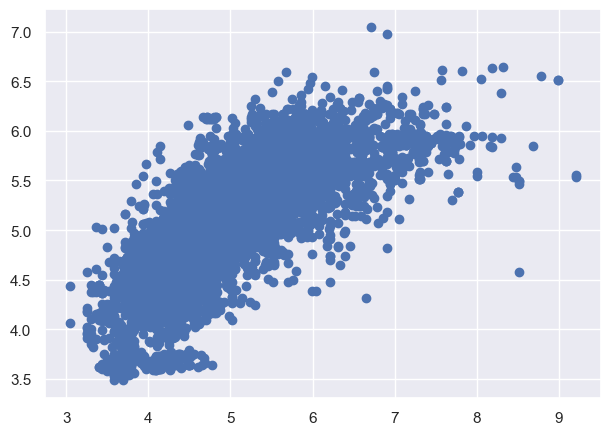

In [45]:
plt.scatter(y_val, gbr.predict(X_val))

GradientBoostingRegressor seemed to be the model with the least amount of Overfitting

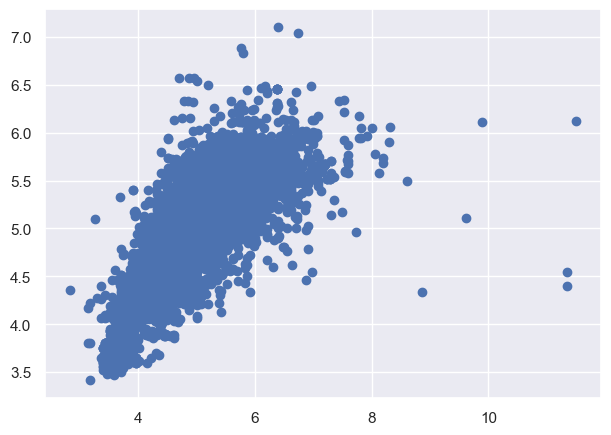

In [46]:
plt.scatter(y_test, gbr.predict(X_test))

In [3]:
r2(y_test, gbr.predict(X_test))

NameError: name 'r2' is not defined

In [59]:
mae(y_test, gbr.predict(X_test))


0.356797476834284